# Working with the `TonnageListAPI`

## Setup
Install the Signal Ocean SDK:

In [ ]:
!pip install signal-ocean

Set your subscription key, acquired here: [https://apis.signalocean.com/profile](https://apis.signalocean.com/profile)

In [2]:
signal_ocean_api_key = ""  # replace with your subscription key


## Retrieving a historical tonnage list
First, we need to create an instance of the `TonnageListAPI`:

In [3]:
from signal_ocean import Connection
from signal_ocean.tonnage_list import TonnageListAPI

connection = Connection(signal_ocean_api_key)
api = TonnageListAPI(connection)



Then, we need to determine the parameters of the **historical tonnage list** (**HTL**). In order to fetch an HTL, we will need to specify:
- a loading port,
- a vessel class,
- a time frame.

Ports and vessel classes can be retrieved through the `get_ports` and `get_vessel_classes` methods:

In [4]:
api.get_vessel_classes()


(VesselClass(id=60, name='VLGCLpg'),
 VesselClass(id=61, name='MidsizeLpg'),
 VesselClass(id=62, name='HandyLpg'),
 VesselClass(id=63, name='SmallLpg'),
 VesselClass(id=69, name='VLOC'),
 VesselClass(id=70, name='Capesize'),
 VesselClass(id=72, name='PostPanamaxDry'),
 VesselClass(id=74, name='PanamaxDry'),
 VesselClass(id=75, name='Supramax'),
 VesselClass(id=76, name='Handymax'),
 VesselClass(id=77, name='Handysize'),
 VesselClass(id=78, name='ULCV'),
 VesselClass(id=79, name='NewPanamaxContainer'),
 VesselClass(id=80, name='PostPanamaxContainer'),
 VesselClass(id=81, name='PanamaxContainer'),
 VesselClass(id=82, name='FeedermaxContainer'),
 VesselClass(id=83, name='FeederContainer'),
 VesselClass(id=84, name='VLCC'),
 VesselClass(id=85, name='Suezmax'),
 VesselClass(id=86, name='Aframax'),
 VesselClass(id=87, name='PanamaxTanker'),
 VesselClass(id=88, name='MR2'),
 VesselClass(id=89, name='MR1'),
 VesselClass(id=90, name='Small'),
 VesselClass(id=91, name='LNGLng'),
 VesselClass(id=

Ports can be looked up by their name using the `PortFilter`:

In [5]:
from signal_ocean.tonnage_list import PortFilter

api.get_ports(PortFilter(name_like="rot"))


(Port(id=3689, name='Rotterdam'),
 Port(id=6625, name='Rota'),
 Port(id=8920, name='Crotone'),
 Port(id=15617, name='Rarotonga'))

And so can vessel classes with the use of the `VesselClassFilter`:

In [6]:
from signal_ocean.tonnage_list import VesselClassFilter

api.get_vessel_classes(VesselClassFilter(name_like="MAX"))


(VesselClass(id=72, name='PostPanamaxDry'),
 VesselClass(id=74, name='PanamaxDry'),
 VesselClass(id=75, name='Supramax'),
 VesselClass(id=76, name='Handymax'),
 VesselClass(id=79, name='NewPanamaxContainer'),
 VesselClass(id=80, name='PostPanamaxContainer'),
 VesselClass(id=81, name='PanamaxContainer'),
 VesselClass(id=82, name='FeedermaxContainer'),
 VesselClass(id=85, name='Suezmax'),
 VesselClass(id=86, name='Aframax'),
 VesselClass(id=87, name='PanamaxTanker'))

Note that the search is case-insensitive and does not require specifying exact names.

We want our HTL to contain Aframax vessels in Ceyhan, with a 6-day forward laycan end, for the last 90 days:

In [7]:
from datetime import timedelta, date

vessel_class_filter = VesselClassFilter(name_like="aframax")
vessel_class = api.get_vessel_classes(vessel_class_filter)[0]

port_filter = PortFilter(name_like="ceyhan")
port = api.get_ports(port_filter)[0]

laycan_end_in_days = 6
today = date.today()
start_date = today - timedelta(days=5)


With the parameters above, we can now request an HTL:

In [8]:
from signal_ocean.tonnage_list import DateRange

htl = api.get_historical_tonnage_list(
    port, vessel_class, laycan_end_in_days, DateRange(start_date, today)
)


The resulting historical tonnage list is a Python object that contains a collection of tonnage lists, each of which has a timestamp and a collection of vessel data. The tonnage lists are ordered by date in descending order:

In [9]:
yesterdays_tl = htl[1]
print("Date:", yesterdays_tl.date)
print("Vessel count:", len(yesterdays_tl.vessels))
print("Example vessel:", yesterdays_tl.vessels[0])


Date: 2021-10-12 12:00:00+00:00
Vessel count: 81
Example vessel: Vessel(imo=9486910, name='Beta', vessel_class='Aframax', ice_class=None, year_built=2010, deadweight=105319, length_overall=228.6, breadth_extreme=42, market_deployment='Contract', push_type='Not Pushed', open_port='Rotterdam', open_date=datetime.datetime(2019, 10, 15, 12, 37, 38, 306000, tzinfo=datetime.timezone.utc), operational_status='Laden', commercial_operator='Held Maritime Shipping', commercial_status='Available', eta=datetime.datetime(2019, 10, 27, 9, 0, tzinfo=datetime.timezone.utc), latest_ais=datetime.datetime(2019, 10, 13, 4, 47, 29, tzinfo=datetime.timezone.utc), subclass='Dirty', willing_to_switch_subclass=False, open_prediction_accuracy='Narrow Area', open_areas=(Area(name='Continent', location_taxonomy='Narrow Area'), Area(name='UK Continent', location_taxonomy='Wide Area'), Area(name='Netherlands', location_taxonomy='Country')), availability_port_type='Prediction', availability_date_type='Prediction')


The result can also be converted into a Pandas data frame:

In [10]:
data_frame = htl.to_data_frame()
data_frame

name vessel_class ice_class  \
date                      imo                                               
2021-10-12 12:00:00+00:00 9486910             Beta      Aframax       NaN   
                          9138604  Barakuda Natuna      Aframax       NaN   
                          9038830           Proteo      Aframax       NaN   
                          8508292    Gunung Kemala      Aframax       NaN   
                          9038854     Warrior King      Aframax       NaN   
...                                            ...          ...       ...   
2021-10-08 12:00:00+00:00 9310525  Kythira Warrior      Aframax       NaN   
                          9198159            Qubaa      Aframax       NaN   
                          9482627       Sea Jaguar      Aframax       NaN   
                          9173721         Alexia 3      Aframax       NaN   
                          9696694       STI Alexis      Aframax       NaN   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2021-10-12 12:00:00+00:00 9486910        2010      105319          228.60   
                          9138604        1998      109277          244.60   
                          9038830        1993       99392          243.97   
                          8508292        1986       86962          242.00   
                          9038854        1993       99371          243.97   
...                                       ...         ...             ...   
2021-10-08 12:00:00+00:00 9310525        2006      115338          249.00   
                          9198159        1998      106681          246.00   
                          9482627        2011      114024          249.97   
                          9173721        1999      105401          248.00   
                          9696694        2015      109999          255.90   

                                   breadth_extreme subclass  \
date                      imo                                 
2021-10-12 12:00:00+00:00 9486910               42    Dirty   
                          9138604               42    Clean   
                          9038830               46    Dirty   
                          8508292               42    Dirty   
                          9038854               46    Dirty   
...                                            ...      ...   
2021-10-08 12:00:00+00:00 9310525               44    Dirty   
                          9198159               42    Dirty   
                          9482627               44    Dirty   
                          9173721               43    Dirty   
                          9696694               43    Clean   

                                  market_deployment_point_in_time  \
date                      imo                                       
2021-10-12 12:00:00+00:00 9486910                        Contract   
                          9138604                            Spot   
                          9038830                         Program   
                          8508292                         Program   
                          9038854                         Program   
...                                                           ...   
2021-10-08 12:00:00+00:00 9310525                            Spot   
                          9198159                        Contract   
                          9482627                         Program   
                          9173721                            Spot   
                          9696694                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2021-10-12 12:00:00+00:00 9486910              Not Pushed  ...   
                          9138604              Not Pushed  ...   
                          9038830              Not Pushed  .

### Example 1 - Plotting a supply trend
The data frame format makes it very easy to generate a supply trend plot.

We'll generate a supply trend from the beginning of the year, but we'll also filter the vessel list by looking for vessels that:
- are pushed,
- have a market deployment type of "Relet" or "Spot",
- their commercial status is available, cancelled or failed,
- are crude oil tankers (their vessel subclass is "Dirty"),
- their AIS information is no older than 5 days.

Filtering can be achieved by creating an instance of a `VesselFilter` and passing it to the `get_historical_tonnage_list` method. A `VesselFilter` meeting the above criteria will look as follows:

In [11]:
from signal_ocean.tonnage_list import (
    VesselFilter,
    PushType,
    MarketDeployment,
    CommercialStatus,
    VesselSubclass,
)

vessel_filter = VesselFilter(
    push_types=[PushType.PUSHED],
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT],
    commercial_statuses=[
        CommercialStatus.AVAILABLE,
        CommercialStatus.CANCELLED,
        CommercialStatus.FAILED,
    ],
    vessel_subclass=VesselSubclass.DIRTY,
    latest_ais_since=5,
)


Note the usage of the `PushType`, `MarketDeployment`, `CommercialStatus`, and `VesselSubclass`. These are enum-like classes that contain constants for all the possible values for a given `VesselFilter` parameter. To list the available values for any of the classes, just invoke `list()` on the class:

In [12]:
list(CommercialStatus)

['On Subs', 'Failed', 'Cancelled', 'Available', 'Poss Fixed']

You can use these values directly or use a corresponding class member:

In [13]:
CommercialStatus.ON_SUBS == 'On Subs'

True

Let's get the HTL for our filter:

In [14]:
beginning_of_year = date(today.year, 1, 1)

htl_for_supply_trend = api.get_historical_tonnage_list(
    port,
    vessel_class,
    laycan_end_in_days,
    DateRange(start_date, today),
    vessel_filter=vessel_filter,
)

supply_trend_data_frame = htl_for_supply_trend.to_data_frame()
supply_trend_data_frame


name vessel_class ice_class  \
date                      imo                                                 
2021-10-12 12:00:00+00:00 9592276             Stamos      Aframax       NaN   
                          9395331           Corossol      Aframax       NaN   
                          9334727          Dugi Otok      Aframax        1C   
                          9345441    Aegean Nobility      Aframax       NaN   
                          9694658  Nissos Christiana      Aframax       NaN   
...                                              ...          ...       ...   
2021-10-08 12:00:00+00:00 9321677          Kronviken      Aframax        1A   
                          9389966             Alexia      Aframax       NaN   
                          9528043            Daytona      Aframax       NaN   
                          9796743               Rava      Aframax        1C   
                          9703320      Front Leopard      Aframax        1C   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2021-10-12 12:00:00+00:00 9592276        2012      115666          240.63   
                          9395331        2010      106898          243.80   
                          9334727        2008      108414          247.24   
                          9345441        2007      115814          248.94   
                          9694658        2015      114264          251.00   
...                                       ...         ...             ...   
2021-10-08 12:00:00+00:00 9321677        2006      109999          248.99   
                          9389966        2009      107574          243.80   
                          9528043        2011      115896          248.97   
                          9796743        2017      114385          250.00   
                          9703320        2016      109900          252.00   

                                   breadth_extreme subclass  \
date                      imo                                 
2021-10-12 12:00:00+00:00 9592276               44    Dirty   
                          9395331               42    Dirty   
                          9334727               48    Dirty   
                          9345441               44    Dirty   
                          9694658               45    Dirty   
...                                            ...      ...   
2021-10-08 12:00:00+00:00 9321677               44    Dirty   
                          9389966               42    Dirty   
                          9528043               44    Dirty   
                          9796743               44    Dirty   
                          9703320               44    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2021-10-12 12:00:00+00:00 9592276                            Spot   
                          9395331                            Spot   
                          9334727                            Spot   
                          9345441                            Spot   
                          9694658                            Spot   
...                                                           ...   
2021-10-08 12:00:00+00:00 9321677                           Relet   
                          9389966                            Spot   
                          9528043                            Spot   
                          9796743                            Spot   
                          9703320                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2021-10-12 12:00:00+00:00 9592276                  Pushed  ...   
                          9395331                  Pushed  ...   
                          9334727   

Now, we can generate the plot:

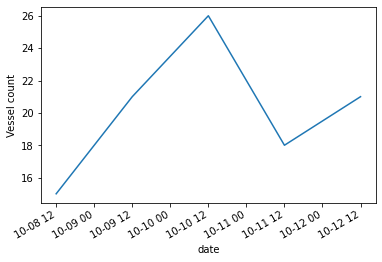

In [15]:
from signal_ocean.tonnage_list import IndexLevel

supply_trend = supply_trend_data_frame.groupby(
    IndexLevel.DATE, sort=True
).size()

plot = supply_trend.plot()
plot.set_ylabel("Vessel count")
plot


### Example 2 - Generating an Excel sheet
The data frame can be easily saved as an Excel file by using Pandas's built-in `to_excel()` function.

Before we do that, we need to remove all the time zone information from all timestamps in the data frame. This is because Excel does not support storing time zone information along with timestamps. However, Signal Ocean's SDK always provides time zone information to make all timestamp-based computation unambiguous.

In [16]:
from signal_ocean.tonnage_list import Column

without_time_zones = (
    supply_trend_data_frame.reset_index()
    .astype(
        {
            IndexLevel.DATE: "datetime64[ns]",
            Column.OPEN_DATE: "datetime64[ns]",
            Column.ETA: "datetime64[ns]",
            Column.LATEST_AIS: "datetime64[ns]",
        }
    )
    .set_index([IndexLevel.DATE, IndexLevel.IMO])
)


Now, we can generate the Excel file:

In [17]:
without_time_zones.to_excel('htl.xlsx')

## Retrieving a live tonnage list
Retrieving a live tonnage list is almost exactly the same as getting a historical one except, instead of using the `get_historical_tonnage_list` method, you use the `get_tonnage_list` method and you don't pass a `DateRange` as an argument. The `get_tonnage_list` method returns a single `TonnageList` that contains live vessel data.

Because of this similarity, we can reuse the parameters we used for our HTL queries:

In [18]:
tonnage_list = api.get_tonnage_list(
    port, vessel_class, laycan_end_in_days, vessel_filter
)
tonnage_list


TonnageList(vessels=(Vessel(imo=9334727, name='Dugi Otok', vessel_class='Aframax', ice_class='1C', year_built=2008, deadweight=108414, length_overall=247.24, breadth_extreme=48, market_deployment='Spot', push_type='Pushed', open_port='Canakkale', open_date=datetime.datetime(2021, 10, 13, 1, 43, 28, tzinfo=datetime.timezone.utc), operational_status='Ballast Unfixed', commercial_operator='Tankerska Plovidba dd', commercial_status='Available', eta=datetime.datetime(2021, 10, 15, 12, 0, tzinfo=datetime.timezone.utc), latest_ais=datetime.datetime(2021, 10, 13, 1, 43, 28, tzinfo=datetime.timezone.utc), subclass='Dirty', willing_to_switch_subclass=False, open_prediction_accuracy='Narrow Area', open_areas=(Area(name='Sea of Marmara', location_taxonomy='Narrow Area'), Area(name='Black Sea / Sea Of Marmara', location_taxonomy='Wide Area'), Area(name='Turkey', location_taxonomy='Country')), availability_port_type='Source', availability_date_type='Source'), Vessel(imo=9395331, name='Corossol', ves

We can also convert the resulting tonnage list to a data frame:

In [19]:
tonnage_list.to_data_frame()

,name,vessel_class,ice_class,year_built,deadweight,length_overall,breadth_extreme,subclass,market_deployment_point_in_time,push_type_point_in_time,...,commercial_operator_point_in_time,commercial_status_point_in_time,eta_point_in_time,latest_ais_point_in_time,open_prediction_accuracy_point_in_time,open_country_point_in_time,open_narrow_area_point_in_time,open_wide_area_point_in_time,availability_port_type_point_in_time,availability_date_type_point_in_time
9334727,Dugi Otok,Aframax,1C,2008,108414,247.24,48,Dirty,Spot,Pushed,...,Tankerska Plovidba dd,Available,2021-10-15 12:00:00+00:00,2021-10-13 01:43:28+00:00,Narrow Area,Turkey,Sea of Marmara,Black Sea / Sea Of Marmara,Source,Source
9395331,Corossol,Aframax,NaN,2010,106898,243.80,42,Dirty,Spot,Pushed,...,Cardiff Marine,Available,2021-10-15 15:00:00+00:00,2021-10-13 08:43:16+00:00,Narrow Area,Greece,East Mediterranean,Mediterranean,Source,Source
9345441,Aegean Nobility,Aframax,NaN,2007,115814,248.94,44,Dirty,Spot,Pushed,...,Arcadia Shipmanagement,Available,2021-10-15 22:00:00+00:00,2021-10-13 08:43:59+00:00,Narrow Area,Greece,East Mediterranean,Mediterranean,Source,Source
9389966,Alexia,Aframax,NaN,2009,107574,243.80,42,Dirty,Spot,Pushed,...,Centrofin,Available,2021-10-16 02:00:00+00:00,2021-10-12 01:05:56+00:00,Narrow Area,Israel,East Mediterranean,Mediterranean,Source,Source
9321677,Kronviken,Aframax,1A,2006,109999,248.99,44,Dirty,Relet,Pushed,...,Vitol,Available,2021-10-16 13:00:00+00:00,2021-10-12 19:47:25+00:00,Narrow Area,Turkey,Sea of Marmara,Black Sea / Sea Of Marmara,Source,Source
9337418,Patmos Warrior,Aframax,NaN,2007,105572,239.00,42,Dirty,Spot,Pushed,...,Polembros Shipping,Available,2021-10-16 20:00:00+00:00,2021-10-13 08:43:41+00:00,Narrow Area,Italy,Central Mediterranean,Mediterranean,Source,Source
9259680,Santa Cruz I,Aframax,NaN,2002,84999,238.94,38,Dirty,Relet,Pushed,...,Avin International,Available,2021-10-16 21:00:00+00:00,2021-10-13 08:40:47+00:00,Narrow Area,Italy,Central Mediterranean,Mediterranean,Source,Source
9694658,Nissos Christiana,Aframax,NaN,2015,114264,251.00,45,Dirty,Spot,Pushed,...,Kyklades Maritime,Available,2021-10-16 23:00:00+00:00,2021-10-13 08:41:57+00:00,Port,Turkey,East Mediterranean,Mediterranean,Source,Prediction
9288710,Delta Captain,Aframax,1A,2005,111009,250.00,44,Dirty,Spot,Pushed,...,Delta Tankers,Available,2021-10-17 00:00:00+00:00,2021-10-13 08:41:53+00:00,Narrow Area,Malta,Central Mediterranean,Mediterranean,Source,Source
9296195,Paros,Aframax,NaN,2003,107197,247.00,42,Dirty,Spot,Pushed,...,New Shipping,Available,2021-10-17 00:00:00+00:00,2021-10-13 08:41:22+00:00,Narrow Area,Malta,Central Mediterranean,Mediterranean,Source,Source
